In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler, OneHotEncoder)
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import (GridSearchCV, cross_val_score)
from sklearn import metrics
import graphviz
from joblib import dump, load
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.neighbors import NeighborhoodComponentsAnalysis
import uilities

In [2]:
# Windows
ROOT = "C:/Users/weiru/OneDrive - University of Leeds/MSc-Lab/datasets"

In [3]:
dataPath = ROOT + "/files/dataset1PTHuse1_400.csv"

In [4]:
df = pd.read_csv(dataPath)

In [5]:
df

,Patient,PTH,Ca,Vit D,Mg,eGFR,Interpretation
0,1,1.1,1.90,72.0,0.1,80,A1
1,2,15.4,2.85,90.0,0.9,66,I
2,3,0.7,1.70,89.0,1.0,90,A2
3,4,2.3,1.90,60.0,0.1,80,B1
4,5,12.2,1.70,32.0,1.0,90,C1
...,...,...,...,...,...,...,...
395,396,15.4,2.85,90.0,0.9,66,I
396,397,0.7,1.70,89.0,1.0,90,A2
397,398,2.3,1.90,60.0,0.1,80,B1
398,399,12.2,1.70,32.0,1.0,90,C1


In [6]:
# Delete Patitent column

df = df.drop(columns=['Patient']).copy()

In [7]:
class DecisionTree():
    
    def __init__(self):
        pass
        
    def removeNull(self, df):
        nonNull_df = df.copy()
        nonNull_df = nonNull_df.dropna(how='any',axis=0)
        return nonNull_df 
    
    def imputedDF(self, df, strategy):
        
        fill_NaN           = SimpleImputer(strategy=strategy)
        df_attr            = df.iloc[:,:-1]

        imputed_DF         = pd.DataFrame(fill_NaN.fit_transform(df_attr))
        imputed_DF.columns = df_attr.columns
        imputed_DF.index   = df_attr.index

        new_df             = imputed_DF.join(df.iloc[:,-1])

        return new_df
    
    
    
    def normalizedDF(self, df):
        normalized            = MinMaxScaler()
        df_attr               = df.iloc[:,:-1]
        normalized_DF         = pd.DataFrame(normalized.fit_transform(df_attr))
        normalized_DF.columns = df_attr.columns
        normalized_DF.index   = df_attr.index
        new_df                = normalized_DF.join(df.iloc[:,-1])
        return new_df
    
    
    
    def standardDF(self, df):
        std_scale      = StandardScaler()
        df_attr        = df.iloc[:,:-1]
        std_DF         = pd.DataFrame(std_scale.fit_transform(df_attr))
        std_DF.columns = df_attr.columns
        std_DF.index   = df_attr.index
        new_df         = std_DF.join(df.iloc[:,-1])
        return new_df
    
    
    
    def checkIsNull(self, df):
        '''
            Check whether the dataframe has nulls
        '''
        if df.isnull().values.any():
            print("Data have nulls")
        else:
            print("Data don't have nulls")
        
        
        
    def pipe(self, CA=""):
        
        RANDOM_STATE = 42
        dtc          = DecisionTreeClassifier(random_state=RANDOM_STATE)
        pca          = PCA()
        lda          = LinearDiscriminantAnalysis()
        nca          = NeighborhoodComponentsAnalysis(random_state=RANDOM_STATE)
        
        dtc_pipe     = Pipeline([('dtc', dtc)])
        pca_pipe     = Pipeline([('pca', pca), ('dtc', dtc)])
        lda_pipe     = Pipeline([('lda', lda), ('dtc', dtc)])
        nca_pipe     = Pipeline([('nca', nca), ('dtc', dtc)])
        
        if CA == 'pca':
            return pca_pipe
        if CA == 'lda':
            return lda_pipe
        if CA == 'nca':
            return nca_pipe
        
        return dtc_pipe
    
    
    
    def trainAndTarg(self, df):
    
        attri  = df.iloc[:,:-1]
        target = df.iloc[:, -1]

        return attri,target
    
    
    
    def print_best_param(self, clf_fit):
        print('Best score : ', clf_fit.best_score_)
        print('Best parameters', clf_fit.best_params_)
        
        
    
    def search__best_param(self, df, pipe, criterion, p=False):
        grid_params = {
            'dtc__criterion'            : [criterion], # 'gini', 'entropy'
            'dtc__max_depth'            : [a for a in range(1,20)],
            'dtc__min_samples_split'    : [b for b in range(2,20)],
            'dtc__min_samples_leaf'     : [c for c in range(1,20)],
    #         'dtc__max_features'         : ['sqrt']

        }
        clf = GridSearchCV(
            pipe,
            grid_params,
            cv=8,
            n_jobs=-1
        )
        
        attri, target = self.trainAndTarg(df)
        clf_fit = clf.fit(attri, target)

        # print parameter
        if p is True:
            self.print_best_param(clf_fit)

        return clf_fit

In [8]:
def search_params(criterion, attri, target):
    dtc         = DecisionTreeClassifier()
    dtc_pipe    = Pipeline([('dtc', dtc)])
    
    
    grid_params = {
        'dtc__criterion'            : [criterion], # 'gini', 'entropy'
        'dtc__max_depth'            : [a for a in range(1,20)],
        'dtc__min_samples_split'    : [b for b in range(2,20)],
        'dtc__min_samples_leaf'     : [c for c in range(1,20)],
#         'dtc__max_features'         : ['sqrt']
        
    }

    clf = GridSearchCV(
        dtc_pipe,
        grid_params,
        cv=8,
        n_jobs=-1
    )
    
    clf_fit = clf.fit(attri, target)
    
    return clf_fit

In [9]:
DTree = DecisionTree()

### Baseline Experiment

#### remove nulls

In [10]:
def runExp1(df,CA):
    nonNull_df    = DTree.removeNull(df)
    pipe          = DTree.pipe(CA)
    criterion     = ['gini', 'entropy']
    clfs          = []
    for c in criterion:
        clfs.append(DTree.search__best_param(df=nonNull_df, pipe=pipe, criterion=c, p=True))

    return clfs

In [11]:
result_n_n = runExp1(df,'')

Best score :  0.9838691026827011
Best parameters {'dtc__criterion': 'gini', 'dtc__max_depth': 8, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}
Best score :  0.967622571692877
Best parameters {'dtc__criterion': 'entropy', 'dtc__max_depth': 8, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 3}


In [12]:
result_pca_n = runExp1(df,'pca')

Best score :  0.7898936170212766
Best parameters {'dtc__criterion': 'gini', 'dtc__max_depth': 10, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 5}
Best score :  0.8192067530064755
Best parameters {'dtc__criterion': 'entropy', 'dtc__max_depth': 10, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}


In [13]:
result_lda_n = runExp1(df,'lda')

Best score :  0.8758672525439408
Best parameters {'dtc__criterion': 'gini', 'dtc__max_depth': 7, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 5}
Best score :  0.8785846438482886
Best parameters {'dtc__criterion': 'entropy', 'dtc__max_depth': 11, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}


#### norm  + remove nulls

In [14]:
def runExp1_2(df,CA):
    nonNull_df    = DTree.removeNull(df)
    norm_df       = DTree.normalizedDF(nonNull_df)
    pipe          = DTree.pipe(CA)
    criterion     = ['gini', 'entropy']
    clfs          = []
    for c in criterion:
        clfs.append(DTree.search__best_param(df=norm_df, pipe=pipe, criterion=c, p=True))

    return clfs

In [15]:
result_n_norm = runExp1_2(df,'')

Best score :  0.9811517113783533
Best parameters {'dtc__criterion': 'gini', 'dtc__max_depth': 8, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}
Best score :  0.9649051803885291
Best parameters {'dtc__criterion': 'entropy', 'dtc__max_depth': 8, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 3}


In [16]:
result_pca_norm = runExp1_2(df,'pca')

Best score :  0.7331753006475485
Best parameters {'dtc__criterion': 'gini', 'dtc__max_depth': 14, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 3}
Best score :  0.7546831637372804
Best parameters {'dtc__criterion': 'entropy', 'dtc__max_depth': 9, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 3}


In [17]:
result_lda_norm = runExp1_2(df,'lda')

Best score :  0.8758672525439408
Best parameters {'dtc__criterion': 'gini', 'dtc__max_depth': 7, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 5}
Best score :  0.8785846438482886
Best parameters {'dtc__criterion': 'entropy', 'dtc__max_depth': 11, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}


#### std + remove nulls

In [18]:
def runExp1_3(df, CA):
    nonNull_df    = DTree.removeNull(df)
    std_df        = DTree.standardDF(nonNull_df)
    pipe          = DTree.pipe(CA)
    criterion     = ['gini', 'entropy']
    clfs          = []
    for c in criterion:
        clfs.append(DTree.search__best_param(df=std_df, pipe=pipe, criterion=c, p=True))

    return clfs

In [19]:
result_n_std = runExp1_3(df,'')

Best score :  0.9838691026827011
Best parameters {'dtc__criterion': 'gini', 'dtc__max_depth': 8, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}
Best score :  0.967622571692877
Best parameters {'dtc__criterion': 'entropy', 'dtc__max_depth': 8, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 3}


In [20]:
result_pca_std = runExp1_3(df,'pca')

Best score :  0.7436401480111008
Best parameters {'dtc__criterion': 'gini', 'dtc__max_depth': 12, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}
Best score :  0.7225370027752082
Best parameters {'dtc__criterion': 'entropy', 'dtc__max_depth': 9, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}


In [21]:
result_lda_std = runExp1_3(df,'lda')

Best score :  0.8758672525439408
Best parameters {'dtc__criterion': 'gini', 'dtc__max_depth': 7, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 5}
Best score :  0.8785846438482886
Best parameters {'dtc__criterion': 'entropy', 'dtc__max_depth': 11, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}


### Control Experiment

#### replace nulls 

In [22]:
def runExp2_1(df, strategy):
    replaced_df   = DTree.imputedDF(df, strategy)
    pipe          = DTree.pipe('')
    criterion     = ['gini', 'entropy']
    clfs          = []
    for c in criterion:
        clfs.append(DTree.search__best_param(df=replaced_df, pipe=pipe, criterion=c, p=True))

    return clfs

In [23]:
result_mean = runExp2_1(df,'mean')

Best score :  0.9575
Best parameters {'dtc__criterion': 'gini', 'dtc__max_depth': 10, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 3}
Best score :  0.9424999999999999
Best parameters {'dtc__criterion': 'entropy', 'dtc__max_depth': 7, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}


In [24]:
result_median = runExp2_1(df,'median')

Best score :  0.9424999999999999
Best parameters {'dtc__criterion': 'gini', 'dtc__max_depth': 9, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 3}
Best score :  0.9249999999999999
Best parameters {'dtc__criterion': 'entropy', 'dtc__max_depth': 8, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}


In [25]:
result_most = runExp2_1(df,'most_frequent')

Best score :  0.945
Best parameters {'dtc__criterion': 'gini', 'dtc__max_depth': 10, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}
Best score :  0.9175
Best parameters {'dtc__criterion': 'entropy', 'dtc__max_depth': 10, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}


#### replace nulls+ std

In [26]:
def runExp2_2(df, strategy):
    replaced_df   = DTree.imputedDF(df, strategy)
    std_df        = DTree.standardDF(replaced_df)
    pipe          = DTree.pipe('')
    criterion     = ['gini', 'entropy']
    clfs          = []
    for c in criterion:
        clfs.append(DTree.search__best_param(df=std_df, pipe=pipe, criterion=c, p=True))

    return clfs

In [27]:
result_mean_std = runExp2_2(df,'mean')

Best score :  0.9575
Best parameters {'dtc__criterion': 'gini', 'dtc__max_depth': 10, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 3}
Best score :  0.945
Best parameters {'dtc__criterion': 'entropy', 'dtc__max_depth': 9, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 5}


In [28]:
result_median_std = runExp2_2(df,'median')

Best score :  0.9424999999999999
Best parameters {'dtc__criterion': 'gini', 'dtc__max_depth': 9, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 3}
Best score :  0.9275
Best parameters {'dtc__criterion': 'entropy', 'dtc__max_depth': 8, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 5}


In [29]:
result_most_std = runExp2_2(df,'most_frequent')

Best score :  0.9475
Best parameters {'dtc__criterion': 'gini', 'dtc__max_depth': 10, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}
Best score :  0.9224999999999999
Best parameters {'dtc__criterion': 'entropy', 'dtc__max_depth': 9, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 3}


#### replace nulls + norm

In [30]:
def runExp2_3(df, strategy):
    replaced_df   = DTree.imputedDF(df, strategy)
    norm_df       = DTree.normalizedDF(replaced_df)
    pipe          = DTree.pipe('')
    criterion     = ['gini', 'entropy']
    clfs          = []
    for c in criterion:
        clfs.append(DTree.search__best_param(df=norm_df, pipe=pipe, criterion=c, p=True))

    return clfs

In [31]:
result_mean_norm = runExp2_3(df,'mean')

Best score :  0.9575
Best parameters {'dtc__criterion': 'gini', 'dtc__max_depth': 10, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 3}
Best score :  0.945
Best parameters {'dtc__criterion': 'entropy', 'dtc__max_depth': 9, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 5}


In [32]:
result_median_norm = runExp2_3(df,'median')

Best score :  0.9424999999999999
Best parameters {'dtc__criterion': 'gini', 'dtc__max_depth': 9, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 3}
Best score :  0.9275
Best parameters {'dtc__criterion': 'entropy', 'dtc__max_depth': 8, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 5}


In [33]:
result_most_norm = runExp2_3(df,'most_frequent')

Best score :  0.945
Best parameters {'dtc__criterion': 'gini', 'dtc__max_depth': 10, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}
Best score :  0.9199999999999999
Best parameters {'dtc__criterion': 'entropy', 'dtc__max_depth': 10, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}


#### replace nulls + norm + PCA / LDA

In [34]:
def runExp2_4(df, strategy, CA):
    replaced_df   = DTree.imputedDF(df, strategy)
    norm_df       = DTree.normalizedDF(replaced_df)
    pipe          = DTree.pipe(CA)
    criterion     = ['gini', 'entropy']
    clfs          = []
    for c in criterion:
        clfs.append(DTree.search__best_param(df=norm_df, pipe=pipe, criterion=c, p=True))

    return clfs

In [35]:
result_mean_pca_norm = runExp2_4(df,'mean','pca')

Best score :  0.68
Best parameters {'dtc__criterion': 'gini', 'dtc__max_depth': 11, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}
Best score :  0.6925
Best parameters {'dtc__criterion': 'entropy', 'dtc__max_depth': 9, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}


In [36]:
result_median_pca_norm = runExp2_4(df,'median', 'pca')

Best score :  0.68
Best parameters {'dtc__criterion': 'gini', 'dtc__max_depth': 16, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}
Best score :  0.6825
Best parameters {'dtc__criterion': 'entropy', 'dtc__max_depth': 10, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}


In [37]:
result_most_pca_norm = runExp2_4(df,'most_frequent', 'pca')

Best score :  0.705
Best parameters {'dtc__criterion': 'gini', 'dtc__max_depth': 13, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}
Best score :  0.7075
Best parameters {'dtc__criterion': 'entropy', 'dtc__max_depth': 12, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}


In [38]:
result_mean_lda_norm = runExp2_4(df,'mean','lda')

Best score :  0.8174999999999999
Best parameters {'dtc__criterion': 'gini', 'dtc__max_depth': 12, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 3}
Best score :  0.805
Best parameters {'dtc__criterion': 'entropy', 'dtc__max_depth': 10, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}


In [39]:
result_median_lda_norm = runExp2_4(df,'median', 'lda')

Best score :  0.8075
Best parameters {'dtc__criterion': 'gini', 'dtc__max_depth': 12, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 3}
Best score :  0.7975000000000001
Best parameters {'dtc__criterion': 'entropy', 'dtc__max_depth': 10, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}


In [40]:
result_most_lda_norm = runExp2_4(df,'most_frequent', 'lda')

Best score :  0.8175
Best parameters {'dtc__criterion': 'gini', 'dtc__max_depth': 11, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 3}
Best score :  0.8025
Best parameters {'dtc__criterion': 'entropy', 'dtc__max_depth': 10, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}


### Runtime Experiment

In [41]:
def runExp3_1(df, scale):
    nonNull_df    = DTree.removeNull(df)
    std_df        = DTree.standardDF(nonNull_df)
    norm_df       = DTree.normalizedDF(nonNull_df)
    pipe          = DTree.pipe('')
    
    if scale == '':
        search_df = nonNull_df
    if scale == 'std':
        search_df = std_df
    if scale == 'norm':
        search_df = norm_df
    criterion     = ['gini', 'entropy']
    clfs          = []
    _time         = []
    
    for c in criterion:
        start_time = time.time()
        clfs.append(DTree.search__best_param(df=search_df, pipe=pipe, criterion=c, p=True))
        end_time   = time.time()
        _time.append(end_time-start_time)
        
    print("avge time is ", np.mean(_time))
    
    return clfs

In [42]:
time_nonnull = runExp3_1(df, '')

Best score :  0.9838691026827011
Best parameters {'dtc__criterion': 'gini', 'dtc__max_depth': 8, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}
Best score :  0.967622571692877
Best parameters {'dtc__criterion': 'entropy', 'dtc__max_depth': 8, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 3}
avge time is  19.99660360813141


In [43]:
time_norm = runExp3_1(df, 'norm')

Best score :  0.9811517113783533
Best parameters {'dtc__criterion': 'gini', 'dtc__max_depth': 8, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}
Best score :  0.9649051803885291
Best parameters {'dtc__criterion': 'entropy', 'dtc__max_depth': 8, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 3}
avge time is  18.627832055091858


In [44]:
time_std = runExp3_1(df, 'std')

Best score :  0.9838691026827011
Best parameters {'dtc__criterion': 'gini', 'dtc__max_depth': 8, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 2}
Best score :  0.967622571692877
Best parameters {'dtc__criterion': 'entropy', 'dtc__max_depth': 8, 'dtc__min_samples_leaf': 1, 'dtc__min_samples_split': 3}
avge time is  18.61284565925598


### Evaluation

In [45]:
clf = time_nonnull[0]
clf.best_estimator_

Pipeline(steps=[('dtc', DecisionTreeClassifier(max_depth=8, random_state=42))])

In [46]:
attri, target = DTree.trainAndTarg(DTree.removeNull(df))

In [47]:
scores = cross_val_score(clf.best_estimator_, attri, target, n_jobs=-1,cv=8, scoring='accuracy')
print(scores)
print('mean score : ', scores.mean())

[0.95744681 0.9787234  0.97826087 0.97826087 1.         1.
 1.         0.97826087]
mean score :  0.9838691026827011


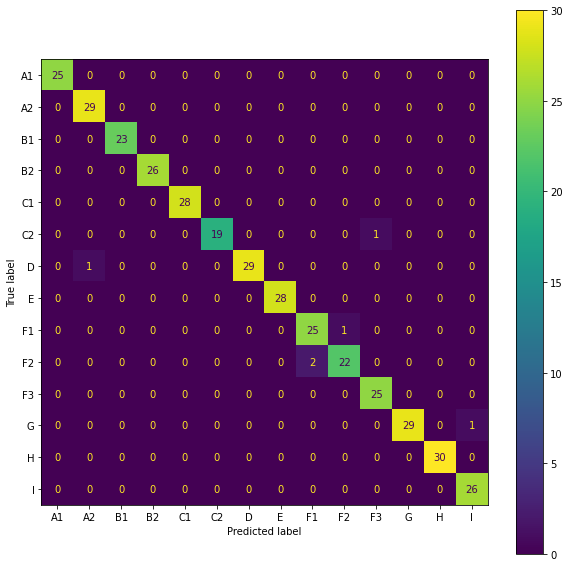

              precision    recall  f1-score   support

          A1       1.00      1.00      1.00        25
          A2       0.97      1.00      0.98        29
          B1       1.00      1.00      1.00        23
          B2       1.00      1.00      1.00        26
          C1       1.00      1.00      1.00        28
          C2       1.00      0.95      0.97        20
           D       1.00      0.97      0.98        30
           E       1.00      1.00      1.00        28
          F1       0.93      0.96      0.94        26
          F2       0.96      0.92      0.94        24
          F3       0.96      1.00      0.98        25
           G       1.00      0.97      0.98        30
           H       1.00      1.00      1.00        30
           I       0.96      1.00      0.98        26

    accuracy                           0.98       370
   macro avg       0.98      0.98      0.98       370
weighted avg       0.98      0.98      0.98       370



In [48]:
y_pred = cross_val_predict(clf.best_estimator_, attri, target, n_jobs=-1,cv=8)
conf_mat = confusion_matrix(target, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_mat,
    display_labels=clf.classes_
)
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(False)
disp.plot(ax=ax)
plt.show()
print(classification_report(target, y_pred))

In [49]:
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in clf.classes_:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(target)==l,
                                                      np.array(y_pred)==l,
                                                      pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])
    
sen_spe_df = pd.DataFrame(res,columns = ['class','specificity','sensitivity'])
sen_spe_df

,class,specificity,sensitivity
0,A1,1.000000,1.000000
1,A2,0.997067,1.000000
2,B1,1.000000,1.000000
3,B2,1.000000,1.000000
4,C1,1.000000,1.000000
5,C2,1.000000,0.950000
6,D,1.000000,0.966667
7,E,1.000000,1.000000
8,F1,0.994186,0.961538
9,F2,0.997110,0.916667


In [50]:
# specificity = tn/(tn+fp)
sen_spe_df['specificity'].mean()

0.9987541281651966

In [51]:
# sensitivity TP/(TP+FN)
sen_spe_df['sensitivity'].mean()

0.9829670329670329